In [2]:
import numpy as np 
import pandas as pd 
import os
import shutil
import cv2
import random
import matplotlib.pyplot as plt
import copy
import wandb

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/human-faces-object-detection/faces.csv
/kaggle/input/human-faces-object-detection/images/00002129.jpg
/kaggle/input/human-faces-object-detection/images/00001760.jpg
/kaggle/input/human-faces-object-detection/images/00001158.jpg
/kaggle/input/human-faces-object-detection/images/00001981.jpg
/kaggle/input/human-faces-object-detection/images/00000503.jpg
/kaggle/input/human-faces-object-detection/images/00001965.jpg
/kaggle/input/human-faces-object-detection/images/00001491.jpg
/kaggle/input/human-faces-object-detection/images/00001985.jpg
/kaggle/input/human-faces-object-detection/images/00002145.jpg
/kaggle/input/human-faces-object-detection/images/00000601.jpg
/kaggle/input/human-faces-object-detection/images/00001179.jpg
/kaggle/input/human-faces-object-detection/images/00003048.jpg
/kaggle/input/human-faces-object-detection/images/00003437.jpg
/kaggle/input/human-faces-object-detection/images/00000848.jpg
/kaggle/input/human-faces-object-detection/images/00000567.jpg
/k

In [3]:
#Importing necessary libraries and installing Ultralytics

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import torch
import subprocess
subprocess.run(["pip", "install", "ultralytics"])
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='eb4c4a1fa7eec1ffbabc36420ba1166f797d4ac5')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: faf2001f (faf2001f-university-of-engineering-and-technology-taxila). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# File paths
image_dir = "/kaggle/input/human-faces-object-detection/images"
csv_path = "/kaggle/input/human-faces-object-detection/faces.csv"
output_dir = "/kaggle/output"

In [6]:
# Load the dataset
faces_df = pd.read_csv(csv_path)

In [7]:
# EDA
print(faces_df.head())
print(faces_df.info())
print(faces_df.describe())

data_len=len(faces_df)
print(data_len)


     image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  3350 non-null   object
 1   width       3350 non-null   int64 
 2   height      3350 non-null   int64 
 3   x0          3350 non-null   int64 
 4   y0          3350 non-null   int64 
 5   x1          3350 non-null   int64 
 6   y1          3350 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 183.3+ KB
None
             width       height           x0           y0           x1  \
count  3350.000000  3350.000000  3350.000000  3350.000000  3350.000000   
mean    967.96716

In [8]:
# Plot distribution of image widths and heights using Plotly
fig = px.histogram(faces_df, x='width', nbins=50, title='Distribution of Image Widths',
                   labels={'width': 'Image Width'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Times New Roman', color='white'))
fig.show()

fig = px.histogram(faces_df, x='height', nbins=50, title='Distribution of Image Heights',
                   labels={'height': 'Image Height'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Times New Roman', color='blue'))
fig.show()

In [9]:
# Plot distribution of bounding box coordinates using Plotly
fig = px.histogram(faces_df, x='x0', nbins=50, title='Distribution of X0 Coordinates',
                   labels={'x0': 'X0 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='y0', nbins=50, title='Distribution of Y0 Coordinates',
                   labels={'y0': 'Y0 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='x1', nbins=50, title='Distribution of X1 Coordinates',
                   labels={'x1': 'X1 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='y1', nbins=50, title='Distribution of Y1 Coordinates',
                   labels={'y1': 'Y1 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

In [10]:
# Convert bounding box coordinates to YOLO format (normalized x_center, y_center, width, height)
def convert_to_yolo(row):
    dw = 1. / row['width']
    dh = 1. / row['height']
    x = (row['x0'] + row['x1']) / 2.0
    y = (row['y0'] + row['y1']) / 2.0
    w = row['x1'] - row['x0']
    h = row['y1'] - row['y0']
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return x, y, w, h

faces_df[['x', 'y', 'w', 'h']] = faces_df.apply(convert_to_yolo, axis=1, result_type='expand')

In [11]:
# Split the dataset into train and validation sets
train_df, val_df = train_test_split(faces_df, test_size=0.2, random_state=42)

In [12]:
# Create YOLO annotation files
annotations_dir = os.path.join(output_dir, 'annotations')
os.makedirs(annotations_dir, exist_ok=True)

for idx, row in faces_df.iterrows():
    annotation_path = os.path.join(annotations_dir, row['image_name'].replace('.jpg', '.txt'))
    with open(annotation_path, 'w') as f:
        f.write(f"0 {row['x']} {row['y']} {row['w']} {row['h']}\n")

In [13]:
# Function to create YOLO annotation files
def create_annotations(df, annotations_dir):
    os.makedirs(annotations_dir, exist_ok=True)
    for idx, row in df.iterrows():
        annotation_path = os.path.join(annotations_dir, row['image_name'].replace('.jpg', '.txt'))
        with open(annotation_path, 'w') as f:
            f.write(f"0 {row['x']} {row['y']} {row['w']} {row['h']}\n")

# Create YOLO annotation files for train and validation sets
train_annotations_dir = os.path.join(output_dir, 'train', 'labels')
val_annotations_dir = os.path.join(output_dir, 'val', 'labels')

create_annotations(train_df, train_annotations_dir)
create_annotations(val_df, val_annotations_dir)

In [14]:
# Image preprocessing
def preprocess_images(image_list, source_dir, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for img_name in image_list:
        img_path = os.path.join(source_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            target_path = os.path.join(target_dir, img_name)
            cv2.imwrite(target_path, img)

train_images_dir = os.path.join(output_dir, 'train', 'images')
val_images_dir = os.path.join(output_dir, 'val', 'images')

preprocess_images(train_df['image_name'].tolist(), image_dir, train_images_dir)
preprocess_images(val_df['image_name'].tolist(), image_dir, val_images_dir)

# Verify annotation files
print("Train annotations sample:")
print(os.listdir(train_annotations_dir)[:5])

print("Validation annotations sample:")
print(os.listdir(val_annotations_dir)[:5])

Train annotations sample:
['00002912.txt', '00001317.txt', '00002680.txt', '00002283.txt', '00001337.txt']
Validation annotations sample:
['00002943.txt', '00000567.txt', '00001646.txt', '00001687.txt', '00002239.txt']


In [15]:
yolo_model = YOLO('yolov8n.yaml') 

In [16]:
# Define the data.yaml file content dynamically
class_names = ['face']
data_yaml_content = f"""
train: {train_images_dir}
val: {val_images_dir}
nc: {len(class_names)}
names: {class_names}
"""

# Save the data.yaml file
data_yaml_path = os.path.join(output_dir, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

In [1]:
# Train the model
yolo_model.train(data=data_yaml_path, epochs=10, imgsz=640)

NameError: name 'yolo_model' is not defined


image 1/1 /kaggle/output/val/images/00001448.jpg: 480x640 2 faces, 140.3ms
Speed: 3.5ms preprocess, 140.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)



image 1/1 /kaggle/output/val/images/00001275.jpg: 640x544 1 face, 152.3ms
Speed: 3.8ms preprocess, 152.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)
image 1/1 /kaggle/output/val/images/00002619.jpg: 448x640 2 faces, 135.2ms
Speed: 2.9ms preprocess, 135.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


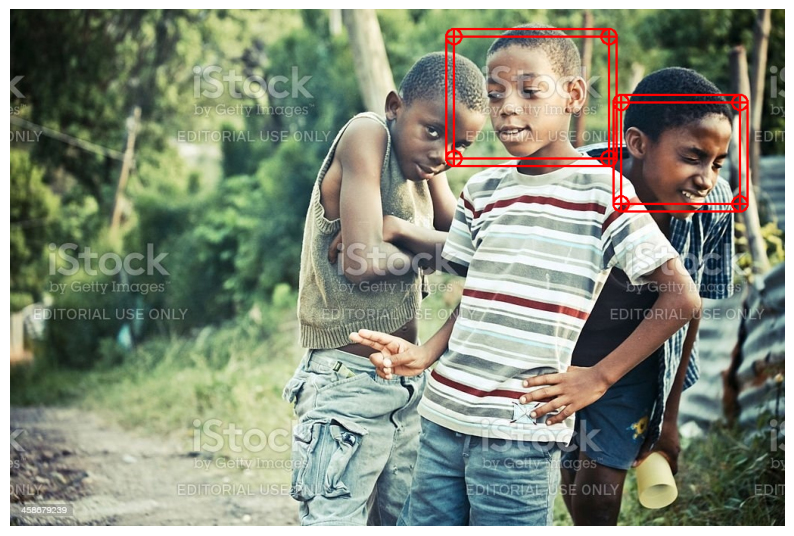


image 1/1 /kaggle/output/val/images/00003288.jpg: 640x512 1 face, 167.0ms
Speed: 2.6ms preprocess, 167.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


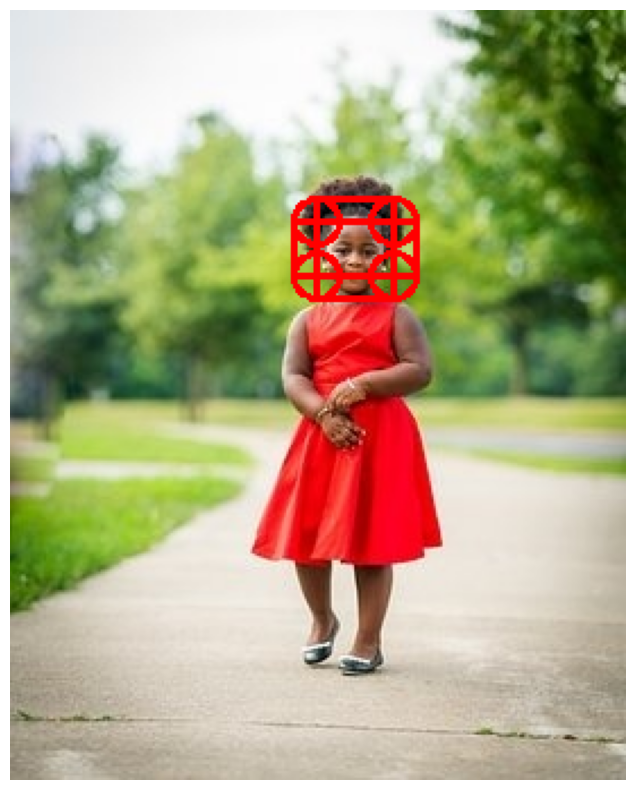


image 1/1 /kaggle/output/val/images/00000597.jpg: 384x640 (no detections), 114.9ms
Speed: 3.2ms preprocess, 114.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


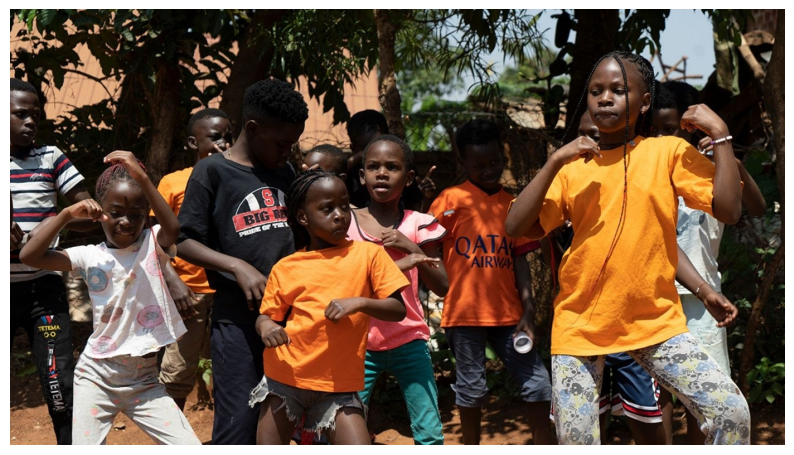


image 1/1 /kaggle/output/val/images/00002923.jpg: 448x640 1 face, 105.7ms
Speed: 3.0ms preprocess, 105.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


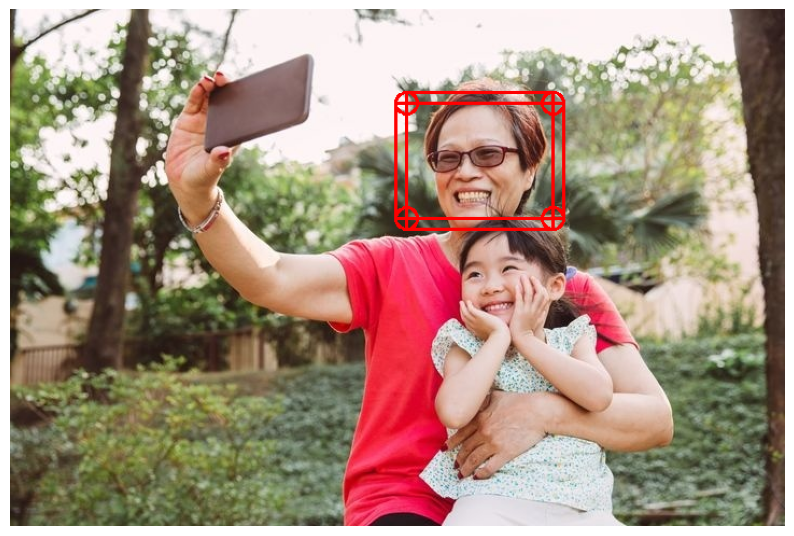


image 1/1 /kaggle/output/val/images/00001368.jpg: 480x640 2 faces, 108.2ms
Speed: 5.0ms preprocess, 108.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


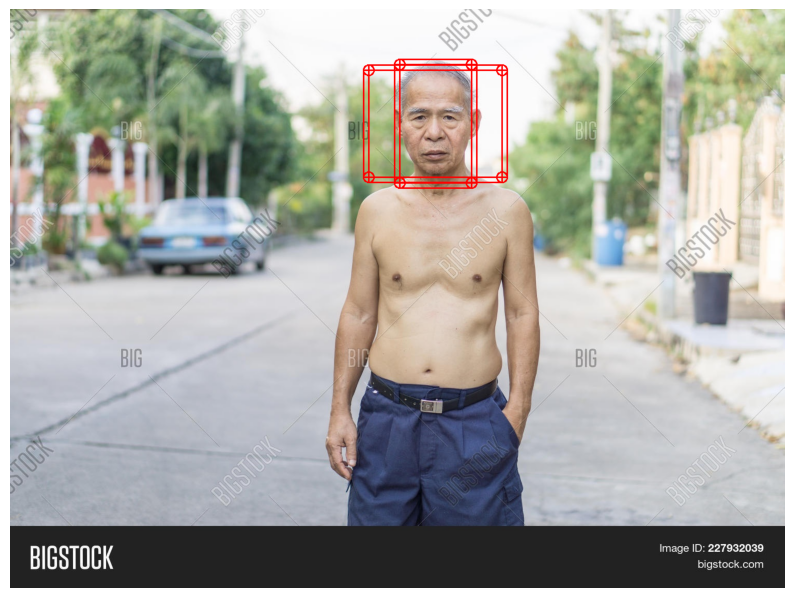


image 1/1 /kaggle/output/val/images/00003027.jpg: 448x640 (no detections), 103.0ms
Speed: 5.0ms preprocess, 103.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


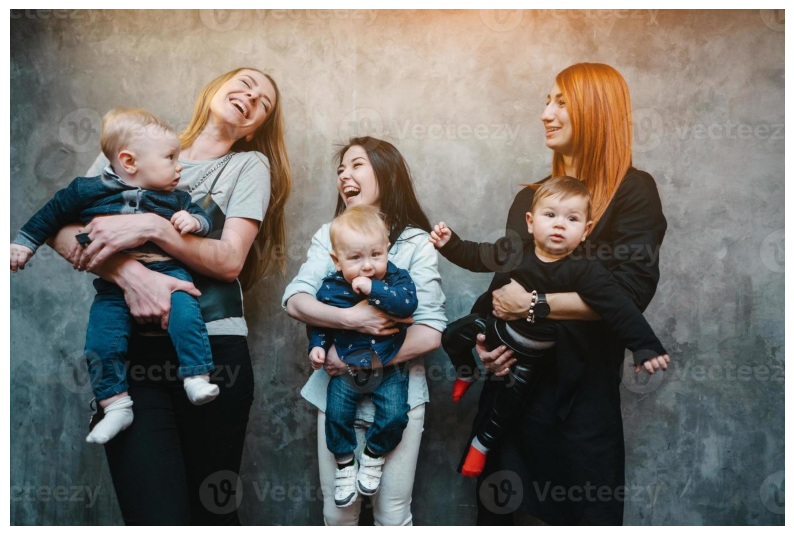


image 1/1 /kaggle/output/val/images/00001990.jpg: 640x448 1 face, 124.3ms
Speed: 3.4ms preprocess, 124.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


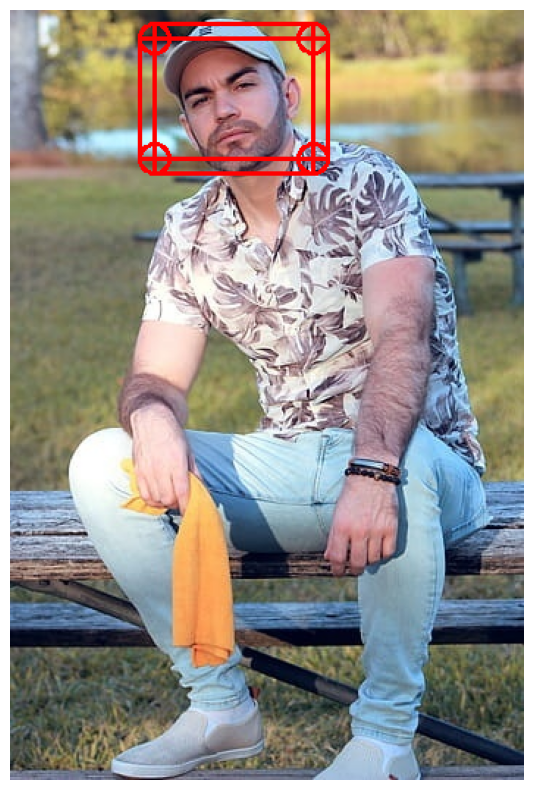


image 1/1 /kaggle/output/val/images/00000231.jpg: 448x640 (no detections), 104.7ms
Speed: 2.9ms preprocess, 104.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


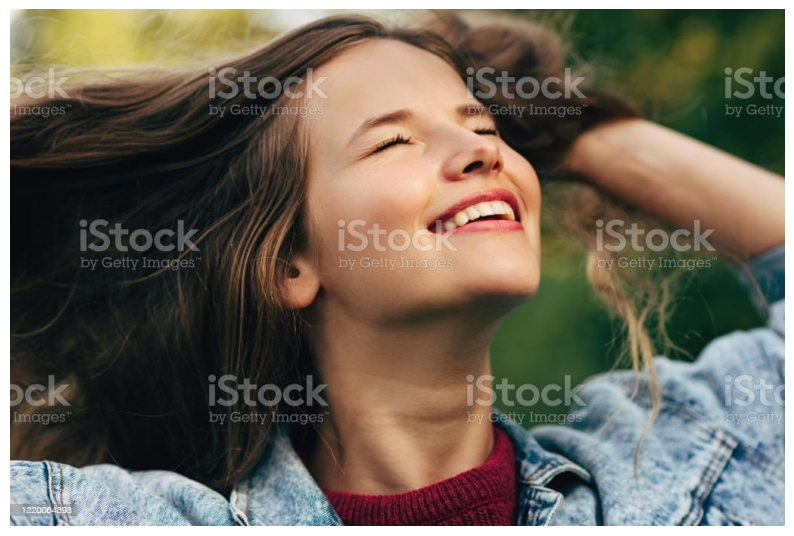

Process completed. Outputs are stored in: /kaggle/output


In [18]:
# all_images = os.listdir(image_dir)
# selected_images = all_images[:50]

# for img_name in selected_images:
#     img_path = os.path.join(image_dir, img_name) 
#     results = model.predict(img_path)
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 


# def display_samples_with_detections(model, images_dir, samples=10):
#     sample_images = os.listdir(images_dir)[:samples]
#     for img_name in sample_images:
#         img_path = os.path.join(images_dir, img_name)
#         results = model(img_path)[0]  # Get the first (and only) Results object
#         img = cv2.imread(img_path)
#     for result in results:
#         plotted_img = result.plot()
#         plt.figure(figsize=(8, 6))  
#         plt.imshow(plotted_img)    
#         plt.axis('off')             
#         plt.show()     

# display_samples_with_detections(yolo_model, val_images_dir)

# print("Process completed. Outputs are stored in:", output_dir)








# Function to draw rounded rectangle
def draw_rounded_rectangle(img, start_point, end_point, color, thickness, radius):
    x1, y1 = start_point
    x2, y2 = end_point
    img = cv2.rectangle(img, (x1 + radius, y1), (x2 - radius, y2), color, thickness)
    img = cv2.rectangle(img, (x1, y1 + radius), (x2, y2 - radius), color, thickness)
    img = cv2.circle(img, (x1 + radius, y1 + radius), radius, color, thickness)
    img = cv2.circle(img, (x2 - radius, y1 + radius), radius, color, thickness)
    img = cv2.circle(img, (x1 + radius, y2 - radius), radius, color, thickness)
    img = cv2.circle(img, (x2 - radius, y2 - radius), radius, color, thickness)
    return img

# Display 10 sample images with detection results
def display_samples_with_detections(model, images_dir, samples=10):
    sample_images = os.listdir(images_dir)[:samples]
    for img_name in sample_images:
        img_path = os.path.join(images_dir, img_name)
        results = model(img_path)[0]  # Get the first (and only) Results object
        img = cv2.imread(img_path)
        for box in results.boxes.xyxy.cpu().numpy():  # x1, y1, x2, y2
            x1, y1, x2, y2 = map(int, box)
            img = draw_rounded_rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2, 10)  # Red color, thickness 2, radius 10
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

display_samples_with_detections(yolo_model, val_images_dir)

print("Process completed. Outputs are stored in:", output_dir)